<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [260]:
import numpy as np
import gensim
import os
import re
import sys

# lda is in scikit learn but gensim is way better apparently
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

# Visz!
import pyLDAvis.gensim
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from gensim.models.ldamulticore import LdaMulticore

# Regulars
import spacy
import pandas as pd
import warnings

In [261]:
warnings.filterwarnings('ignore')

In [262]:
nlp = spacy.load("en_core_web_lg")

In [263]:
import pandas as pd

yelp = pd.read_json('./data/review_sample.json', lines=True)

In [264]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [265]:
yelp.describe()

,cool,funny,stars,useful
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.564800,0.468900,3.735800,1.363600
std,2.040298,1.801043,1.461647,3.129085
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,4.000000,0.000000
75%,0.000000,0.000000,5.000000,2.000000
max,61.000000,79.000000,5.000000,62.000000


## Padescribe Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [266]:
def tokenize(doc):
    """
    Accepts one document, return tokens of that document
    Should be applied via .apply to a dataframe
    """
    return [token for token in simple_preprocess(doc, deacc=True) if (token not in STOPWORDS)]

In [267]:
# This is without cleaning it or brushing it up for consumption
yelp['tk'] = yelp['text'].apply(lambda x: tokenize(x))

In [268]:
yelp.head(5)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,tk
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w,"[beware, fake, fake, fake, small, business, lo..."
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA,"[came, lunch, togo, service, quick, staff, fri..."
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA,"[ve, vegas, dozens, times, stepped, foot, circ..."
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ,"[went, night, closed, street, party, best, act..."
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA,"[stars, bad, price, lunch, seniors, pay, eatin..."


## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [269]:
STOPPIES = nlp.Defaults.stop_words.union([
    'food', 'place', 'got', 'come', 'went', 'try',
    'it','the', 'b\'', 'b\"', '\\n', 'b',
    'place', 'come', '$', '+', ' '])

In [270]:
data = list(yelp.text)
vekkie = CountVectorizer(stop_words=STOPWORDS, min_df=0.05, max_df=0.90)
vekkie.fit(data)
v_dtm = vekkie.transform(data)
dtm = pd.DataFrame(v_dtm.todense(), columns=v.get_feature_names())

In [271]:
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [272]:
# I thought this was Amazon..I legit forgot we're doing Yelp...
fake_rev = ["""
I tried using this for my bunyans and by golly...the stuff just works.
Not only do I have an aching desire to fight for freedom but now
I can do it with a pep in my step.
"""]
new = vekkie.transform(fake_rev)

In [273]:
a = nn.kneighbors(new.todense())

In [274]:
# Teacher's function to read results hehe
def read_results(arr):
    arr_in = arr[1][0]
    x = 1
    for n in arr_in:
        print(f'{x}: {data[n][:200]}\n')
        x+=1

In [275]:
read_results(a)

1: Sour margaritas and just OK carne fries. Glad we didn't stay beyond that. Stomach kinda hurt now.

2: This hotel forces you to sign a consent form, which you will receive at the reception desk. If you refuse to sign, your hotel reservation will be canceled.
By signing the consent form, you are comprom

3: Closed   There's other guns there or you can walk around the mall to burn calories. It's sad but it's closed

4: Leaving Luci's because there are ZERO vegan options! Get with the program Luci's... so bummed :(

5: O  o  thenk 6nnn  .b  cgv  xx TV cvg  9 nvehxcfvvv3c nb b  c  y4  nb and the vghvhridd h 0d  c       v   3,  vv  4  ruddy



- Awesome, super weird reviews...just what I was looking for. The weirdness is definitely a pattern...'get with the program Luci's'

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [299]:
# Did not include a custom tokenizer=<tokenizingfunc>
def tokenize(document):
    doc = nlp(document)
    return [token.lemma_ for token in doc if (token not in STOPPIES)]
#vect = TfidfVectorizer(tokenizer=tokenize) # oui
vect = TfidfVectorizer(stop_words=STOPPIES) # oui
clf = RandomForestClassifier()
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=10)

In [300]:
lsi = Pipeline([('vect',vect),('svd',svd)])

In [301]:
pipe = Pipeline([('vect',vect),('clf',clf)])

In [302]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__min_df': (.02, .05),
    'vect__max_features': (100, 500),
    'clf__n_estimators':(5, 10, 25),
    'clf__max_depth':(5,10,15)
}

In [303]:
grid_search = GridSearchCV(pipe, parameters, cv=10, n_jobs=-1, verbose=1)
grid_search.fit(yelp.text, yelp.stars)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  2.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__min_df': (0.02, 0.05), 'vect__max_features': (100, 500), 'clf__n_estimators': (5, 10, 25), 'clf__max_depth': (5, 10, 15)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [304]:
pred = grid_search.predict(fake_rev)

In [305]:
print(pred)

[5]


A five-star review seems accurate for my fake review.

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Keep the `iterations` parameter at or below 5 to reduce run time
    - The `workers` parameter should match the number of physical cores on your machine.
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

Learn the vocubalary of the yelp data:

In [306]:
def print_id2word_stats(id2word):
    print(f'''
    id2word size: {sys.getsizeof(id2word)}
    id2word length: {len(id2word.keys())}''')

In [307]:
id2word = corpora.Dictionary(yelp.tk)

In [308]:
print_id2word_stats(id2word)


    id2word size: 56
    id2word length: 26372


In [309]:
id2word.filter_extremes(no_below=3, no_above=.975)

In [310]:
print_id2word_stats(id2word)


    id2word size: 56
    id2word length: 10598


Wow a huge reduction...

Create a bag of words representation of the entire corpus

In [311]:
corpus = [id2word.doc2bow(t) for t in yelp.tk]

In [312]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

Your LDA model should be ready for estimation: 

In [313]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   iterations=5,
                   workers=4,
                   num_topics = 10 # You can change this parameter
                  )

It ran fine, but I always get a wall of red text so I had to clear output

In [314]:
lda

In [315]:
lda.print_topics()

[(0,
  '0.011*"food" + 0.011*"service" + 0.010*"great" + 0.009*"place" + 0.009*"good" + 0.007*"time" + 0.007*"like" + 0.005*"nice" + 0.005*"got" + 0.005*"order"'),
 (1,
  '0.011*"food" + 0.011*"good" + 0.009*"place" + 0.008*"time" + 0.008*"service" + 0.007*"great" + 0.007*"like" + 0.005*"got" + 0.005*"nice" + 0.004*"order"'),
 (2,
  '0.015*"good" + 0.011*"food" + 0.010*"place" + 0.007*"like" + 0.006*"service" + 0.006*"time" + 0.006*"ve" + 0.006*"great" + 0.005*"staff" + 0.005*"ordered"'),
 (3,
  '0.011*"great" + 0.011*"good" + 0.010*"food" + 0.010*"service" + 0.009*"place" + 0.007*"like" + 0.006*"time" + 0.005*"got" + 0.004*"come" + 0.004*"amazing"'),
 (4,
  '0.012*"place" + 0.010*"food" + 0.010*"good" + 0.009*"time" + 0.009*"great" + 0.007*"like" + 0.007*"service" + 0.004*"best" + 0.004*"little" + 0.004*"ve"'),
 (5,
  '0.014*"place" + 0.011*"food" + 0.010*"like" + 0.009*"good" + 0.007*"great" + 0.007*"service" + 0.006*"time" + 0.005*"love" + 0.005*"best" + 0.005*"got"'),
 (6,
  '0.010

In [316]:
# This regex is absolutely not from me...lmao thx teacher
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]

In [317]:
topics

['food service great place good',
 'food good place time service',
 'good food place like service',
 'great good food service place',
 'place food good time great',
 'place food like good great',
 'food place service like good',
 'great place food good time',
 'food place great service time',
 'great good food place time']

What kind of results are these...something is off but not sure.

Create 1-2 visualizations of the results

## Visuals!

In [318]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.005575 -0.000297       1        1  10.386003
9     -0.001085 -0.003682       2        1  10.254562
4     -0.000162 -0.000458       3        1  10.112282
2     -0.004990 -0.000568       4        1  10.052672
3      0.001022 -0.002309       5        1  10.044746
0      0.001839  0.002183       6        1  10.006726
7     -0.000321 -0.002839       7        1   9.905366
6     -0.002185  0.004164       8        1   9.847663
1     -0.000190  0.000896       9        1   9.745279
5      0.000497  0.002911      10        1   9.644699, topic_info=     Category         Freq        Term        Total  loglift  logprob
201   Default  4248.000000       great  4248.000000  30.0000  30.0000
39    Default  4593.000000        good  4593.000000  29.0000  29.0000
44    Default  3613.000000     service  3613.000000  28.0000  28.0000
703   Default  1638.000000        love  1638.000000  27.0000  27.0000
112   Default  1475.000000        went  1475.000000  26.0000  26.0000
128   Default  4704.000000       place  4704.000000  25.0000  25.0000
367   Default  1414.000000      little  1414.000000  24.0000  24.0000
373   Default  1495.000000       order  1495.000000  23.0000  23.0000
1171  Default  1534.000000     ordered  1534.000000  22.0000  22.0000
33    Default  3402.000000        time  3402.000000  21.0000  21.0000
72    Default  2048.000000         got  2048.000000  20.0000  20.0000
187   Default  1352.000000     amazing  1352.000000  19.0000  19.0000
426   Default  1204.000000         day  1204.000000  18.0000  18.0000
425   Default   824.000000    customer   824.000000  17.0000  17.0000
45    Default  1553.000000       staff  1553.000000  16.0000  16.0000
346   Default  1231.000000   delicious  1231.000000  15.0000  15.0000
99    Default   949.000000        room   949.000000  14.0000  14.0000
110   Default  1913.000000          ve  1913.000000  13.0000  13.0000
139   Default  4903.000000        food  4903.000000  12.0000  12.0000
338   Default  1446.000000        come  1446.000000  11.0000  11.0000
17    Default  3436.000000        like  3436.000000  10.0000  10.0000
175   Default  1230.000000        menu  1230.000000   9.0000   9.0000
117   Default  1806.000000        best  1806.000000   8.0000   8.0000
357   Default   932.000000       fresh   932.000000   7.0000   7.0000
254   Default  1288.000000  experience  1288.000000   6.0000   6.0000
380   Default   785.000000       pizza   785.000000   5.0000   5.0000
738   Default   391.000000        fish   391.000000   4.0000   4.0000
626   Default  1372.000000  restaurant  1372.000000   3.0000   3.0000
104   Default   949.000000        sure   949.000000   2.0000   2.0000
35    Default   970.000000        wait   970.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
373   Topic10   170.234024       order  1495.546021   0.1657  -5.5602
776   Topic10    69.159904       visit   556.817810   0.2529  -6.4609
139   Topic10   464.878845        food  4903.625977  -0.0172  -4.5556
940   Topic10    83.661354     looking   697.870667   0.2175  -6.2706
775   Topic10    55.889977     usually   443.131104   0.2683  -6.6740
594   Topic10    90.881088        wasn   780.623901   0.1882  -6.1878
751   Topic10    66.475227       sushi   545.875549   0.2332  -6.5005
72    Topic10   202.276627         got  2048.025635   0.0238  -5.3877
111   Topic10   102.018723       vegas   907.288025   0.1535  -6.0722
44    Topic10   322.474030     service  3613.553711  -0.0777  -4.9213
132   Topic10   111.346710         bar  1012.957031   0.1308  -5.9847
39    Topic10   388.914459        good  4593.509277  -0.1303  -4.7340
992   Topic10   123.220520         new  1153.118896   0.1025  -5.8834
88    Topic10   169.550247        nice  1742.420288   0.0089  -5.5642
367   Topic10   143.534225      little  1414.447388   0.0508  -5.7308
345   Topic10   145

#### Words

- From the dataset off the bat we see that the average amount of stars is 3.7~.

In [319]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,10)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [320]:
len(new_distro)

10000

In [321]:
yelp.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,tk
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w,"[beware, fake, fake, fake, small, business, lo..."
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA,"[came, lunch, togo, service, quick, staff, fri..."
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA,"[ve, vegas, dozens, times, stepped, foot, circ..."


In [322]:
df = pd.DataFrame.from_records(new_distro, index=list(yelp.user_id))

In [323]:
df.describe()

,0,1,2,3,4,5,6,7,8,9
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.099635,0.093966,0.099975,0.099989,0.103335,0.094517,0.097880,0.098310,0.108859,0.103026
std,0.053226,0.050024,0.056840,0.054928,0.057003,0.053836,0.056768,0.054996,0.062125,0.053711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.068797,0.064483,0.066634,0.068307,0.071220,0.064327,0.065603,0.068523,0.073936,0.071269
50%,0.093763,0.089516,0.093427,0.093345,0.096449,0.088891,0.090198,0.092700,0.098826,0.096585
75%,0.121803,0.116301,0.122363,0.120744,0.124830,0.115786,0.119718,0.119406,0.130403,0.125905
max,0.684950,0.814577,0.873335,0.870570,0.897529,0.816668,0.855515,0.870688,0.831134,0.783916


In [324]:
df

,0,1,2,3,4,5,6,7,8,9
n1LM36qNg4rqGXIcvVXv8w,0.043319,0.123701,0.098067,0.085714,0.049215,0.184389,0.188462,0.047833,0.067690,0.111607
5CgjjDAic2-FAvCtiHpytA,0.051480,0.054247,0.206999,0.124766,0.128278,0.016317,0.141166,0.096042,0.079779,0.100925
BdV-cf3LScmb8kZ7iiBcMA,0.060972,0.156300,0.091922,0.092559,0.078543,0.099626,0.077737,0.160076,0.074899,0.107367
cZZnBqh4gAEy4CdNvJailQ,0.123839,0.062140,0.055738,0.101268,0.046961,0.156537,0.082797,0.089943,0.091043,0.189733
n9QO4ClYAS7h9fpQwa5bhA,0.105328,0.118605,0.107319,0.077654,0.104123,0.163742,0.099519,0.054090,0.101938,0.067681
Gjz2PCbLZ6midk1n_0LaUg,0.074867,0.099880,0.260385,0.054764,0.084440,0.047398,0.204776,0.029939,0.054887,0.088666
BeKPVuqX-2at4izqVwUFEg,0.066074,0.076656,0.059824,0.099872,0.104572,0.104377,0.156170,0.092899,0.150451,0.089103
PuXpIJzTBQejeBZh9hwynQ,0.093994,0.269690,0.040891,0.097498,0.102728,0.046121,0.052250,0.117494,0.089943,0.089390
NVVknS1I51z8wY5NNrJ6vQ,0.083322,0.097678,0.049175,0.087965,0.108786,0.126230,0.093568,0.127186,0.103979,0.122111
J7MsJKJDSA5OGo2-Hn7MbA,0.096431,0.089582,0.108794,0.110425,0.052718,0.085935,0.064919,0.155569,0.092305,0.143321


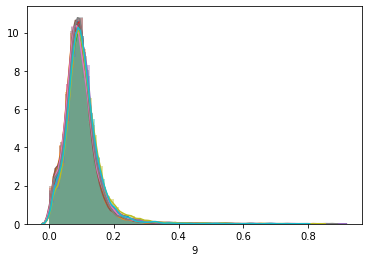

In [325]:
for n in range(10):
    sns.distplot(df[n])

In [326]:
# Teacher's function that I am borrowing(!)
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [327]:
# Use the Function
wc = count(yelp['tk'])

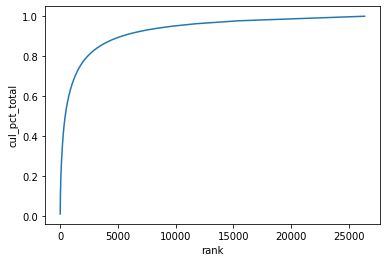

In [328]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc)

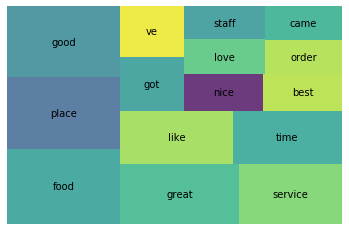

In [329]:
toppie = wc[wc['rank'] <= 15]

squarify.plot(sizes=toppie['pct_total'], label=toppie['word'], alpha=0.8)
plt.axis('off')
plt.show()

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* [ ] Incorporate named entity recognition into your analysis
* [ ] Compare vectorization methods in the classification section
* [ ] Analyze more (or all) of the yelp dataset - this one is v. hard. 
* [ ] Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* [ ] Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)

In [330]:
def pronoun_hunter(doc):
    people = []
    for d in doc:
        x = nlp(d)
        for ent in x.ents:
            if ent.label_ == "PERSON":
                people.append(ent.lemma_)
    return set(people)

I tried this with a small subset and it worked...but maybe I didn't make it good enough to work with so much data

In [ ]:
yelp['pronouns'] = yelp['text'].apply(lambda x: pronoun_hunter(x))

In [ ]:
yelp.head(10)